In [ ]:
from google.colab import files
up = files.upload()

Saving archive.zip to archive.zip


In [ ]:
!unzip archive.zip -d archive > /dev/null

In [ ]:
import cv2
import inspect
from keras import Sequential, applications
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import matplotlib.pyplot as plt
import random
from timeit import default_timer as timer
from tqdm import tqdm

- 데이터 탐색

In [ ]:
train_dir = 'archive/Face_Mask_Dataset/Train'
validation_dir = 'archive/Face_Mask_Dataset/Validation'
test_dir = 'archive/Face_Mask_Dataset/Test'
train_withmask_dir = 'archive/Face_Mask_Dataset/Train/WithMask'
train_withoutmask_dir = 'archive/Face_Mask_Dataset/Train/WithoutMask'
test_withmask_dir = 'archive/Face_Mask_Dataset/Test/WithMask'
test_withoutmask_dir = 'archive/Face_Mask_Dataset/Test/WithoutMask'
validation_withmask_dir = 'archive/Face_Mask_Dataset/Validation/WithMask'
validation_withoutmask_dir = 'archive/Face_Mask_Dataset/Validation/WithoutMask'

In [ ]:
# 파일 이름
import os 
train_withmask_fnames = os.listdir(train_withmask_dir)
train_withoutmask_fnames = os.listdir(train_withoutmask_dir)

test_withmask_fnames = os.listdir(test_withmask_dir)
test_withoutmask_fnames = os.listdir(test_withoutmask_dir)
print(train_withmask_fnames[:5])
print(train_withoutmask_fnames[:5])

['1103.png', '198.png', 'Augmented_764_4043256.png', 'Augmented_589_4758569.png', 'Augmented_22_7814468.png']
['2401.png', '1103.png', '4296.png', '198.png', '5830.png']


In [ ]:
# 파일 갯수 
len(train_withmask_fnames), len(train_withoutmask_fnames)

(5000, 5000)

In [ ]:
len(test_withmask_fnames), len(test_withoutmask_fnames)

(483, 509)

- 이미지 확인

In [ ]:
import cv2
from PIL import Image



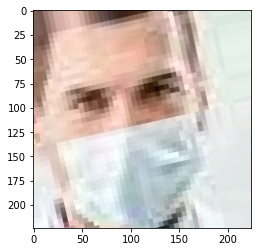

In [ ]:
fname = os.path.join(train_withmask_dir, 'Augmented_157_5707542.png')
img = Image.open(fname)
plt.imshow(img)

- 마스크 쓴 이미지, 안 쓴 이미지 각각 4개씩 도출


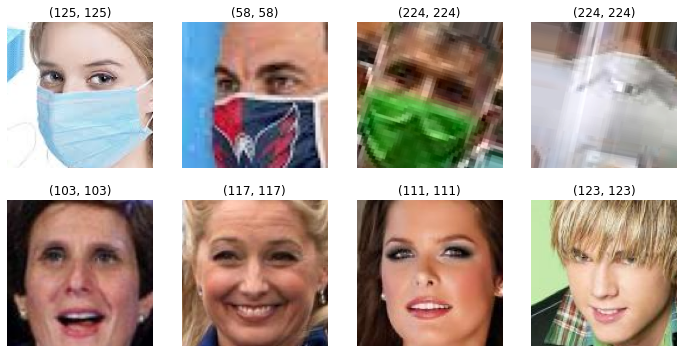

In [ ]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2,4, i + 1)
    withmask = cv2.imread(os.path.join(train_withmask_dir, train_withmask_fnames[i]))[:,:,::-1]
    plt.imshow(withmask), plt.axis('off'), plt.title(withmask.shape[:-1])
    
    plt.subplot(2,4 ,i + 5)
    withoutmask = cv2.imread(os.path.join(train_withoutmask_dir, train_withoutmask_fnames[i]))[:,:,::-1]
    plt.imshow(withoutmask), plt.axis('off'), plt.title(withoutmask.shape[:-1])

Data Augmentation
- 훈련 데이터의 과적합을 방지하기 위해 데이터 부풀리기 적용
- 이를 위해서 image Data Generator를 사용 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255., # 255개의 RGB values에 맞춰서 축소
    rotation_range=15, # 기울어진 얼굴
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=[0.8, 2.0], # 확대된 얼굴
    horizontal_flip=True, # 좌우 반전된 얼굴
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255) # validation

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img = load_img('archive/Face_Mask_Dataset/Train/WithMask/1008.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x.shape

(1, 116, 116, 3)

In [ ]:
train_data_generator = train_datagen.flow_from_directory(
    'archive/Face_Mask_Dataset/Train',
    target_size=(224,224),
    batch_size=20,
    class_mode='binary'
)


Found 10000 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255.)
test_data_generator = test_datagen.flow_from_directory(
    'archive/Face_Mask_Dataset/Test',
    target_size=(224,224),
    batch_size=20,
    class_mode='binary'
)

Found 992 images belonging to 2 classes.


- 데이터 가공 전 모델 정확도 예측

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
model = Sequential([
                    Conv2D(16, kernel_size =(3,3), input_shape =(224,224,3), activation= 'relu'),
                    MaxPooling2D(),
                    Dropout(0.25),
                    Conv2D(32, (3,3), activation= 'relu'),
                    MaxPooling2D(), 
                    Dropout(0.25),
                    Conv2D(64, (3,3), activation= 'relu'),
                    MaxPooling2D(),
                    Flatten(), 
                    Dense(64, activation= 'relu'),
                    Dropout(0.5),
                    Dense(1, activation= 'sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)        0

In [ ]:
model.compile(
    optimizer= 'adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

- Callback 정의

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-face_mask-v3.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

In [ ]:
hist = model.fit(
    train_data_generator,   # 훈련데이터셋을 제공할 제네레이터
    steps_per_epoch=500,     
    epochs=100, verbose=1,
    validation_data=test_data_generator,    # 검증데이터셋을 제공할 제네레이터
    validation_steps=100,      # 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수
    callbacks=[checkpoint, early_stop]
)

In [ ]:
model.evaluate(test_data_generator, steps=5)

- ResNet 활용

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
res50 = ResNet50()

In [ ]:
from tensorflow.keras.applications.resnet import ResNet101
res101 = ResNet101()

In [ ]:
import numpy as np
from PIL import Image
from google.colab import files
up = files.upload()

In [ ]:
IMAGE_SIZE = 224

def center_image(img):
    h, w, _ = np.array(img).shape
    if h > w:
        width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
    else:
        width, height = (w * IMAGE_SIZE) // h, IMAGE_SIZE

    new_img = np.array(img.resize((width,height)))

    diff = abs(width - height)//2
    if width > height:
        final_img = new_img[:, diff:diff+IMAGE_SIZE, :]
    else:
        final_img = new_img[diff:diff+IMAGE_SIZE, :, :]

    return final_img

In [ ]:
import matplotlib.pyplot as plt

img = Image.open('puppy.jpg')
img2 = center_image(img)
plt.imshow(img2), plt.axis('off');

In [ ]:
yhat = res50.predict(np.array(img2).reshape(-1,224,224,3))
label = decode_predictions(yhat)
yhat.shape, label

In [ ]:
yhat = res101.predict(np.array(img2).reshape(-1,224,224,3))
label = decode_predictions(yhat)
label[0][0][1], label[0][0][2]